# Kaggle Competetion 
- Using Colab
- Colab Pro (High-RAM mode) is required. Otherwise, the resnet50 will crush program due to RAM overflow

#### Part 1: Import Training Data

- Upload dataset 5_shot.zip to colab (should be in '/content/')
- Run the following cells to:
  - Unzip the file to maintain the directory
  - Create 'train.txt' for all the training data in the format: "folder/image,label", such as "0/2.jpg, 0......"
  - Create 'test.txt' for all the testing data in the format: "image,label", such as "2.jpg, 0......"
  - Import data into pytorch dataset and dataloader

In [2]:
# Uncomment this line if unzip the dataset
!unzip 5_shot.zip

Archive:  5_shot.zip
   creating: 5_shot/
   creating: 5_shot/test/
  inflating: 5_shot/test/0.jpg       
  inflating: 5_shot/test/1.jpg       
  inflating: 5_shot/test/10.jpg      
  inflating: 5_shot/test/100.jpg     
  inflating: 5_shot/test/101.jpg     
  inflating: 5_shot/test/102.jpg     
  inflating: 5_shot/test/103.jpg     
  inflating: 5_shot/test/104.jpg     
  inflating: 5_shot/test/105.jpg     
  inflating: 5_shot/test/106.jpg     
  inflating: 5_shot/test/107.jpg     
  inflating: 5_shot/test/108.jpg     
  inflating: 5_shot/test/109.jpg     
  inflating: 5_shot/test/11.jpg      
  inflating: 5_shot/test/110.jpg     
  inflating: 5_shot/test/111.jpg     
  inflating: 5_shot/test/112.jpg     
  inflating: 5_shot/test/113.jpg     
  inflating: 5_shot/test/114.jpg     
  inflating: 5_shot/test/115.jpg     
  inflating: 5_shot/test/116.jpg     
  inflating: 5_shot/test/117.jpg     
  inflating: 5_shot/test/118.jpg     
  inflating: 5_shot/test/119.jpg     
  inflating: 5_shot/

In [3]:
x0 = 4
x1 = 3
x2 = 247
x3 = 929
x4 = 31
x5 = 5.4
x6 = 7.2
x7 = 0.5
x8 = 3980
x9 = 6
w0 = 0.91
w1 = 0.81
w2 = 0.42
w3 = 0.23
w4 = -0.13
w5 = 0.22
w6 = 0.09
w7 = 0.25
w8 = 0.12
w9 = 0.39
w1*x0 +w2*x2 +w3*x3 +w4*x4 +w5*x5 +w6*x6 +w7*x7 +w8*x8 +w9*x9 

798.5210000000001

In [3]:
import os
import pandas as pd
import numpy as np
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import argparse
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from IPython.display import Image, display
import torchvision.models as models
import gc

# script parameters
batch_size = 10

# run on GPU if possible
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

# connect to a directory with
os.chdir("/content/5_shot/train")

# os.listdir(dirname) returns the list of filenames in the named directory
filenames = os.listdir(".")

# create a txt file for the training set
with open('train.txt', 'w') as f:
  f.write('image,label\n')
  for i in range(22):
    path = './' + str(i)
    for j in os.listdir(path):
      image = str(i) + '/' + str(j) + ',' + str(i) + '\n'
      f.write(image)

# connect to a directory with
os.chdir("/content/5_shot/test")

# create a txt file for the training set
with open('test.txt', 'w') as f:
  f.write('image,label\n')
  for i in range(517):
    image = str(i) + '.jpg,' + str(0) + '\n'
    f.write(image)

In [4]:
# Using CustomImageDataset from Pytorch Tutorial: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html 
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        image = image / 255.
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
      
crop_transform = transforms.Compose([ transforms.ColorJitter(brightness=.5, hue=.3),transforms.Lambda(lambda crops: torch.stack([crop for crop in crops]))])
scale_transform = transforms.Compose([ transforms.CenterCrop((500,1000))])

# target transform
def tt(i):
  return torch.full((4,),i)

# Create Dataset and Dataloader
training_data = CustomImageDataset('/content/5_shot/train/train.txt','/content/5_shot/train/')
center_training_data = CustomImageDataset('/content/5_shot/train/train.txt','/content/5_shot/train/',scale_transform)
crop_training_data = CustomImageDataset('/content/5_shot/train/train.txt','/content/5_shot/train/',crop_transform)

train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
center_train_loader = DataLoader(center_training_data, batch_size=batch_size, shuffle=True)
crop_train_loader = DataLoader(crop_training_data, batch_size=batch_size, shuffle=True)

test_set = CustomImageDataset('/content/5_shot/test/test.txt','/content/5_shot/test/')
test_loader = DataLoader(test_set, batch_size=batch_size)

#### Part 2: Train Model

In [5]:
def train(epoch, model, optimizer, loss_fn, train_loader=train_loader):
    gc.collect()
    train_BCE = 0
    for batch_idx, (data, l) in enumerate(train_loader):
        data = data.to(device)
        l = l.to(device)
        optimizer.zero_grad()
        batch_pred = model(data)
        loss = loss_fn(batch_pred, l.type(torch.LongTensor).to(device))
        loss.backward()
        train_BCE += loss.item()
        optimizer.step()

    average_train_BCE = train_BCE / len(train_loader.dataset)
    return average_train_BCE

# train augmented dataset such as FiveCrop
def crop_train(epoch, model, optimizer, loss_fn, train_loader=train_loader):
    gc.collect()
    train_BCE = 0
    for batch_idx, (data, l) in enumerate(train_loader):
        data = data.to(device)
        l = l.to(device)
        optimizer.zero_grad()
        bat, i, c, h, w = data.shape
        batch_pred = model(data.view(-1,c,h,w))
        loss = loss_fn(batch_pred, l.view(-1).type(torch.LongTensor).to(device))
        loss.backward()
        train_BCE += loss.item()
        optimizer.step()

    average_train_BCE = train_BCE / len(train_loader.dataset)
    return average_train_BCE

#### Part 3: Main
- I used ResNet50 model, trained with 50 epochs. 
- Different training data set by augmentation and transformation: 
  - The first data set is augmented, that all images are center cropped. 
  - The second one is the color transformed by using ColorJitter. Training with different brightness seems very helpful. 
  - The third one is the original set.
- Different training optimizors are compared: Adam is more realistic than SGD, since it converges faster.

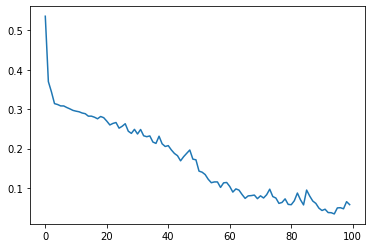

In [9]:
# train the ResNet model
epochs = 50
train_BCE = []
model_SGD = models.resnet50(pretrained=True).to(device)
model_SGD.fc = nn.Linear(model_SGD.fc.in_features, 22).to(device)
optimizer = optim.SGD(model_SGD.parameters(), lr=0.1, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()

for epoch in range(1, epochs + 1):
    average_train_BCE = train(epoch, model_SGD, optimizer, loss_fn, crop_train_loader)
    train_BCE.append(average_train_BCE)

for epoch in range(1, epochs + 1):
    average_train_BCE = train(epoch, model_SGD, optimizer, loss_fn)
    train_BCE.append(average_train_BCE)

plt.plot(train_BCE)
plt.show()

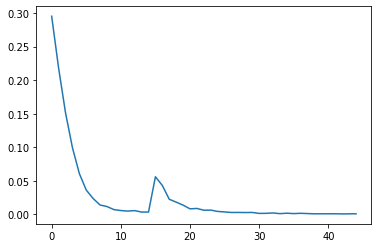

In [10]:
# train the ResNet model
epochs = 15
train_BCE = []
model = models.resnet50(pretrained=True).to(device)
model.fc = nn.Linear(model.fc.in_features, 22).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

for epoch in range(1, epochs + 1):
    average_train_BCE = train(epoch, model, optimizer, loss_fn, center_train_loader)
    train_BCE.append(average_train_BCE)

for epoch in range(1, epochs + 1):
    average_train_BCE = train(epoch, model, optimizer, loss_fn, crop_train_loader)
    train_BCE.append(average_train_BCE)

for epoch in range(1, epochs + 1):
    average_train_BCE = train(epoch, model, optimizer, loss_fn)
    train_BCE.append(average_train_BCE)

plt.plot(train_BCE)
plt.show()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

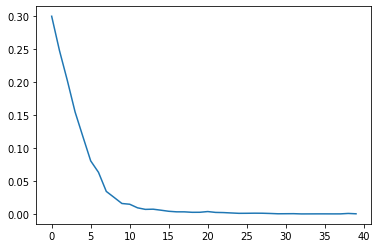

In [6]:
# train the ResNet model
epochs = 20
train_BCE = []
model1 = models.resnet50(pretrained=True).to(device)
model1.fc = nn.Linear(model1.fc.in_features, 22).to(device)
optimizer = optim.Adam(model1.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

for epoch in range(1, epochs + 1):
    average_train_BCE = train(epoch, model1, optimizer, loss_fn, crop_train_loader)
    train_BCE.append(average_train_BCE)

for epoch in range(1, epochs + 1):
    average_train_BCE = train(epoch, model1, optimizer, loss_fn)
    train_BCE.append(average_train_BCE)

plt.plot(train_BCE)
plt.show()

#### Part 4: Generate Predictions

In [8]:
def output(model):
    model.eval()
    acc = torch.tensor([-1])
    with torch.no_grad():
        for i, (data, l) in enumerate(test_loader):
            data = data.to(device)
            l = l.to(device)
            batch_pred = model(data)
            acc = torch.cat((acc,(torch.max(batch_pred,dim=1)[1].to("cpu"))),0)
    return acc

In [10]:
o1 = output(model1)

In [13]:
# Print the predictions to '/content/'
with open('/content/20757202Wang.csv', 'w') as f:
  f.write('id,category\n')
  for i in range(517):
      image = str(i) +  ',' + str(o1[i+1].item()) + '\n'
      f.write(image)